In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['income_data.csv']))
# Dataset is now stored in a Pandas Dataframe
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


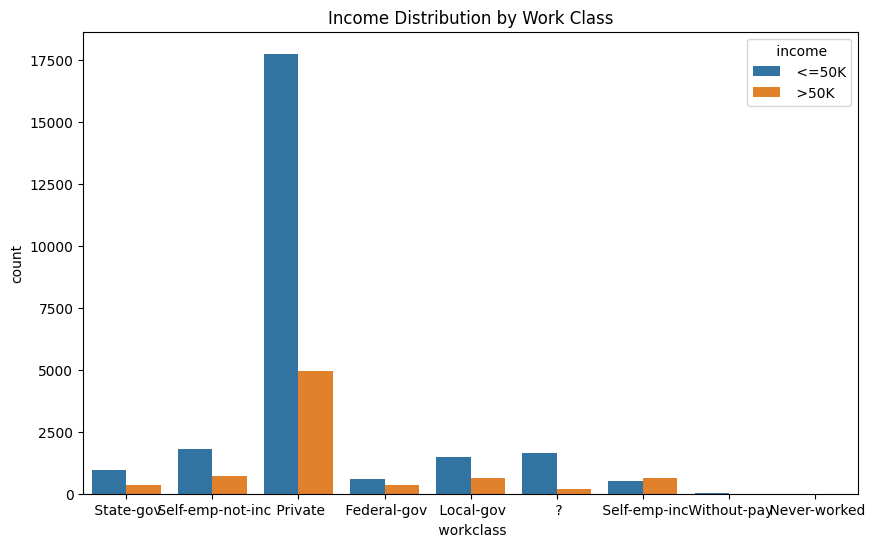

In [ ]:
# Bar plot for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(x=' workclass', hue=' income', data=df)
plt.title('Income Distribution by Work Class')
plt.show()

About 75% of all the records in the dataset have 'private' as the work class. We have very little data on those without pay and those who have never worked.

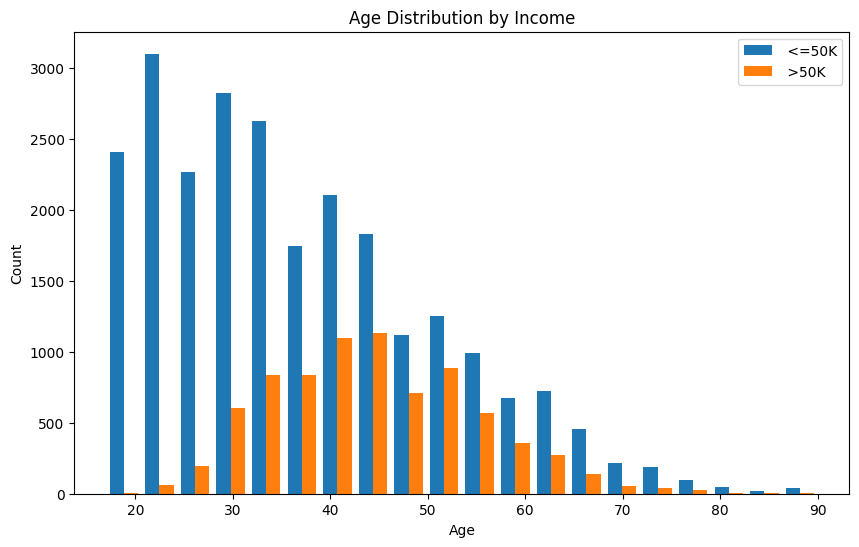

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist([df[df[' income'] == ' <=50K']['age'], df[df[' income'] == ' >50K']['age']], bins=20, label=[' <=50K', ' >50K'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Income')
plt.legend()
plt.show()

We will need to make age bins. Majority of the population sample are between the ages of 20 and 50. We can have smaller range bins here and have larger ranges after 50. Everyone above 70 can be represented under >70.

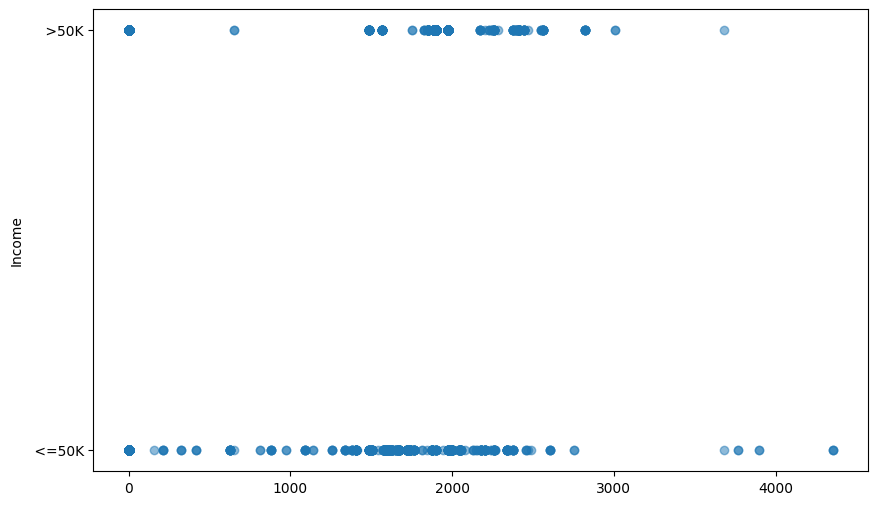

In [ ]:
# Bar plot for categorical features
plt.figure(figsize=(10, 6))
plt.scatter(df[' capital-loss'], df[' income'], alpha=0.5)
plt.ylabel('Income')
plt.show()

People with high capital gains seem to make >50K in income. Majority of people with low capital gains i.e. <2000 make <=50K

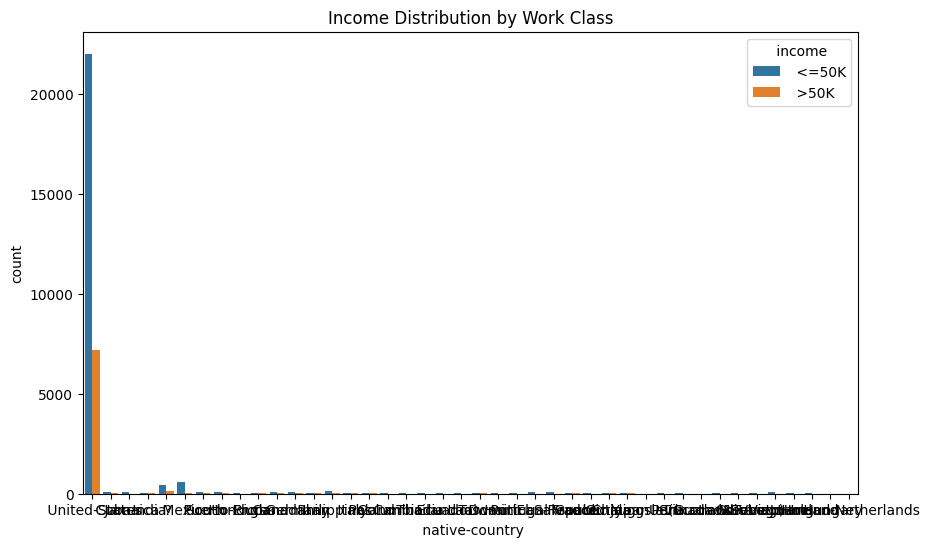

In [ ]:
# Bar plot for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(x=' native-country', hue=' income', data=df)
plt.title('Income Distribution by Work Class')
plt.show()

A lot of the data(over 90%) is from people in the united states. This means we can have 2 unique values in the native-country category, either in the united states or not in the united states.

In [ ]:
missing_values_percentages = df.isnull().sum() / len(df) * 100
missing_values_percentages

age                0.0
 workclass         0.0
 fnlwgt            0.0
 education         0.0
 education-num     0.0
 marital-status    0.0
 occupation        0.0
 relationship      0.0
 race              0.0
 sex               0.0
 capital-gain      0.0
 capital-loss      0.0
 hours-per-week    0.0
 native-country    0.0
 income            0.0
dtype: float64

We don't have any missing values.

In [ ]:
df['age'].describe()

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

Our range of ages seems okay. Lowest being at 17 and highest at 90.

In [ ]:
df[' workclass'].value_counts()

 workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64

A very large percentage of the population works in the private sector. We can use this to fill the missing values.

In [ ]:
mode_workclass = df[' workclass'].mode()[0]
df[' workclass'].replace(' ?', mode_workclass, inplace=True)
df[' workclass'].value_counts()

 workclass
 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64

We can drop the education column since we already have education-num which is the encoded version of the education column.

In [ ]:
df.drop(columns=[' education'], inplace = True)
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education-num', ' marital-status',
       ' occupation', ' relationship', ' race', ' sex', ' capital-gain',
       ' capital-loss', ' hours-per-week', ' native-country', ' income'],
      dtype='object')

In [ ]:
df[' marital-status'].value_counts()

 marital-status
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: count, dtype: int64

We have very limited data for married-spouse-absent and married-AF-spouse. We could combine these columns to married-other.

In [ ]:
df[' marital-status'].replace([' Married-spouse-absent', ' Married-AF-spouse'], ' Married-other', inplace=True)
df[' marital-status'].value_counts()

 marital-status
 Married-civ-spouse    14976
 Never-married         10683
 Divorced               4443
 Separated              1025
 Widowed                 993
 Married-other           441
Name: count, dtype: int64

In [ ]:
df[' occupation'].value_counts()

 occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: count, dtype: int64

In [ ]:
# Calculate counts for '<=50K' and '>50K' income classes for each category
income_counts = {}

for category in df[' occupation'].unique():
    category_data = df[df[' occupation'] == category]
    count_less_50k = category_data[' income'].value_counts().get(' <=50K', 0)
    count_greater_50k = category_data[' income'].value_counts().get(' >50K', 0)
    income_counts[category] = {'<=50K': count_less_50k, '>50K': count_greater_50k}

# Display the dictionary
print("Category : Count of <=50K : Count of >50K")
for category, counts in income_counts.items():
    print(f"{category} : {counts['<=50K']} : {counts['>50K']}")

Category : Count of <=50K : Count of >50K
 Adm-clerical : 3263 : 507
 Exec-managerial : 2098 : 1968
 Handlers-cleaners : 1284 : 86
 Prof-specialty : 2281 : 1859
 Other-service : 3158 : 137
 Sales : 2667 : 983
 Craft-repair : 3170 : 929
 Transport-moving : 1277 : 320
 Farming-fishing : 879 : 115
 Machine-op-inspct : 1752 : 250
 Tech-support : 645 : 283
 ? : 1652 : 191
 Protective-serv : 438 : 211
 Armed-Forces : 8 : 1
 Priv-house-serv : 148 : 1


?, Priv-house-serv and Armed-Forces have a majority of values in the same income class. We can simplify the dataset without sacrificing too much information by combining these classes as other. Additionally, we can now get rid of the unknown category.

In [ ]:
# Combine categories '?' (unknown), 'Armed-Forces', and 'Priv-house-serv' into 'Other'
categories_to_combine = [' ?', ' Armed-Forces', ' Priv-house-serv']
df[' occupation'] = df[' occupation'].replace(categories_to_combine, ' Other')
df[' occupation'].value_counts()

 occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Other                2001
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
Name: count, dtype: int64

In [ ]:
df[' race'].value_counts()

 race
 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: count, dtype: int64

In [ ]:
# Combine 'Amer-Indian-Eskimo' and 'Other' into 'Other'
categories_to_combine = [' Amer-Indian-Eskimo', ' Other']
df[' race'] = df[' race'].replace(categories_to_combine, ' Other')

# Recalculate counts for '<=50K' and '>50K' income classes for each race category
income_counts_race_combined = {}

for race in df[' race'].unique():
    race_data = df[df[' race'] == race]
    count_less_50k = race_data[' income'].value_counts().get(' <=50K', 0)
    count_greater_50k = race_data[' income'].value_counts().get(' >50K', 0)
    income_counts_race_combined[race] = {'<=50K': count_less_50k, '>50K': count_greater_50k}

# Display the updated counts for each race category
print("Race : Count of <=50K : Count of >50K")
for race, counts in income_counts_race_combined.items():
    print(f"{race} : {counts['<=50K']} : {counts['>50K']}")


Race : Count of <=50K : Count of >50K
 White : 20699 : 7117
 Black : 2737 : 387
 Asian-Pac-Islander : 763 : 276
 Other : 521 : 61


In [ ]:
df[' capital-gain'].value_counts()

 capital-gain
0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
1111         1
2538         1
22040        1
4931         1
5060         1
Name: count, Length: 119, dtype: int64

Looking at the value counts for the 'capital-gain' column, we can see that the majority of values are zeros. This suggests that this feature is highly skewed, with a few high values and many zeros.
To better prepare this data for model analysis and classification, we can consider binning these values.

In [ ]:
# Create a DataFrame for analysis
income_vs_capital_gain = df[[' capital-gain', ' income']]

# Group by 'capital-gain' and 'income', then count the occurrences
income_vs_capital_gain_counts = income_vs_capital_gain.groupby([' capital-gain', ' income']).size().unstack(fill_value=0)

# Display the DataFrame
print(income_vs_capital_gain_counts)

 income         <=50K   >50K
 capital-gain               
0               23685   6164
114                 6      0
401                 2      0
594                34      0
914                 8      0
...               ...    ...
25236               0     11
27828               0     34
34095               5      0
41310               2      0
99999               0    159

[119 rows x 2 columns]


It seems that for lower values of capital gain, income is still <=50K while majority of those with capital gain >10,000 have >50K income. Let's try to prove this.

In [ ]:
# Filter the DataFrame for capital-gain values less than 10,000
capital_gain_lt_10000 = df[df[' capital-gain'] < 10000]

# Group by 'income' and count the occurrences
counts_lt_10000 = capital_gain_lt_10000[' income'].value_counts()

# Filter the DataFrame for capital-gain values greater than or equal to 10,000
capital_gain_gte_10000 = df[df[' capital-gain'] >= 10000]

# Group by 'income' and count the occurrences
counts_gte_10000 = capital_gain_gte_10000[' income'].value_counts()

# Display the counts
print("Counts for capital-gain < 10,000:")
print(counts_lt_10000)

print("\nCounts for capital-gain >= 10,000:")
print(counts_gte_10000)

Counts for capital-gain < 10,000:
 income
 <=50K    24706
 >50K      7085
Name: count, dtype: int64

Counts for capital-gain >= 10,000:
 income
 >50K     756
 <=50K     14
Name: count, dtype: int64


Very few individuals with greater than 10,000 capital gain have <=50K income. We can relabel the 'capital-gain' values as binary indicators of high and low capital gains. This will create a new column 'capital_gain_level' where the values are 0 for 'capital-gain' less than 10,000 and 1 for 'capital-gain' greater than or equal to 10,000. This approach simplifies the problem by reducing the dimensionality of the 'capital-gain' feature and makes it easier for models to interpret.

In [ ]:
# Create a new column 'capital_gain_level' with values 0 for < 10000 and 1 for >= 10000
df['capital_gain_level'] = (df[' capital-gain'] >= 10000).astype(int)

# Display the first few rows of the updated DataFrame
print(df.head())

   age          workclass   fnlwgt   education-num       marital-status  \
0   39          State-gov    77516              13        Never-married   
1   50   Self-emp-not-inc    83311              13   Married-civ-spouse   
2   38            Private   215646               9             Divorced   
3   53            Private   234721               7   Married-civ-spouse   
4   28            Private   338409              13   Married-civ-spouse   

           occupation    relationship    race      sex   capital-gain  \
0        Adm-clerical   Not-in-family   White     Male           2174   
1     Exec-managerial         Husband   White     Male              0   
2   Handlers-cleaners   Not-in-family   White     Male              0   
3   Handlers-cleaners         Husband   Black     Male              0   
4      Prof-specialty            Wife   Black   Female              0   

    capital-loss   hours-per-week  native-country  income  capital_gain_level  
0              0              

In [ ]:
df[' hours-per-week'].value_counts()

 hours-per-week
40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
82        1
92        1
87        1
74        1
94        1
Name: count, Length: 94, dtype: int64

In [ ]:
# Count the number of people who work more than 30 hours per week
num_work_more_than_80 = len(df[df[' hours-per-week'] > 80])

# Count the number of people who work less than 30 hours per week
num_work_less_than_10 = len(df[df[' hours-per-week'] < 10])

# Display the counts
print("Number of people who work more than 80 hours per week:", num_work_more_than_80)
print("Number of people who work less than 10 hours per week:", num_work_less_than_10)

Number of people who work more than 80 hours per week: 208
Number of people who work less than 10 hours per week: 458


Very few people work more than 80 hours a week. We can use this information to create bins where the last edge will cover everyone over 80 years.

In [ ]:
# Define the bin edges
bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, np.inf]

# Define the bin labels
#bin_labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '>80']
bin_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
# Create a new column 'hours_per_week_bins' with the bin labels
df['hours_per_week_bins'] = pd.cut(df[' hours-per-week'], bins=bin_edges, labels=bin_labels, right=False)

# Display the first few rows of the DataFrame with the new column
print(df[[' hours-per-week', 'hours_per_week_bins']].head())

    hours-per-week hours_per_week_bins
0               40                   4
1               13                   1
2               40                   4
3               40                   4
4               40                   4


In [ ]:
df[' native-country'].value_counts()

 native-country
 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                 

The United States has the highest number followed by Mexico. We can replace all other values with the label 'other'

In [ ]:
# Replace all countries other than United States and Mexico with 'Other'
df[' native-country'] = df[' native-country'].replace(df[' native-country'].value_counts().index[2:], 'Other')

# Display the updated value counts
print(df[' native-country'].value_counts())

 native-country
 United-States    29170
Other              2748
 Mexico             643
Name: count, dtype: int64


In [ ]:
df['age'].value_counts()

age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: count, Length: 73, dtype: int64

In [ ]:
# Get the lowest age
lowest_age = df['age'].min()

print("The lowest age in the dataset is:", lowest_age)

The lowest age in the dataset is: 17


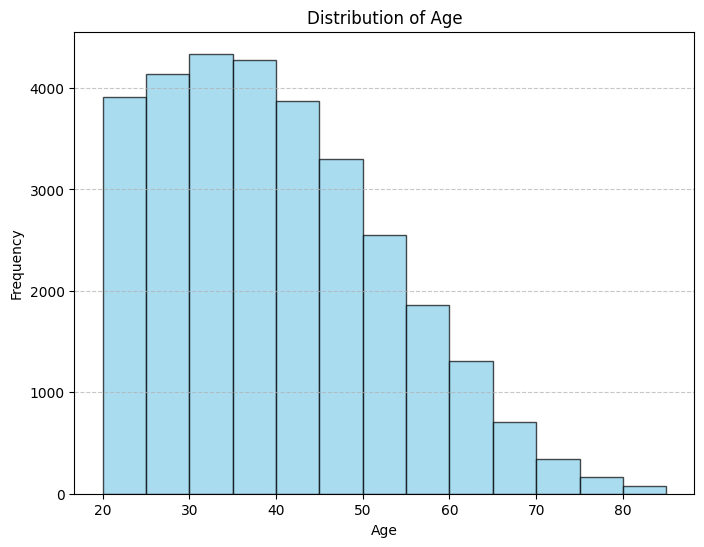

In [ ]:
# Plot histogram of age
plt.figure(figsize=(8, 6))
plt.hist(df['age'], bins=range(20, 90, 5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


-------------Create Age Bins----------------

The lowest age is 17. Our bins will start from 17. The label for the last can be >70.

In [ ]:
# Define the bin edges
bin_edges = [17, 25, 30, 35, 40, 45, 50, 60, 70, np.inf]

# Define the bin labels
bin_labels = ['17-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-60', '60-70', '>70']

# Bin the 'age' column
df['age_bins'] = pd.cut(df['age'], bins=bin_edges, labels=bin_labels, right=False)

# Display the first few rows of the DataFrame with the new column
print(df[['age', 'age_bins']].head())


   age age_bins
0   39    35-40
1   50    50-60
2   38    35-40
3   53    50-60
4   28    25-30


In [ ]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,capital_gain_level,hours_per_week_bins,age_bins
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,4,35-40
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,1,50-60
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,4,35-40
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0,4,50-60
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Other,<=50K,0,4,25-30


Let's drop the columns which we no longer need.

In [ ]:
df.drop(columns=['age', ' hours-per-week', ' capital-gain'], inplace = True)
df.columns

Index([' workclass', ' fnlwgt', ' education-num', ' marital-status',
       ' occupation', ' relationship', ' race', ' sex', ' capital-loss',
       ' native-country', ' income', 'capital_gain_level',
       'hours_per_week_bins', 'age_bins'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0    workclass           32561 non-null  object  
 1    fnlwgt              32561 non-null  int64   
 2    education-num       32561 non-null  int64   
 3    marital-status      32561 non-null  object  
 4    occupation          32561 non-null  object  
 5    relationship        32561 non-null  object  
 6    race                32561 non-null  object  
 7    sex                 32561 non-null  object  
 8    capital-loss        32561 non-null  int64   
 9    native-country      32561 non-null  object  
 10   income              32561 non-null  object  
 11  capital_gain_level   32561 non-null  int64   
 12  hours_per_week_bins  32561 non-null  category
 13  age_bins             32561 non-null  category
dtypes: category(2), int64(4), object(8)
memory usage: 3.0+ MB


In [ ]:
# one-hot encoding the categorical columns
cat_cols = [' workclass', ' marital-status', ' occupation', ' relationship', ' race', ' sex', ' native-country', ' income', 'hours_per_week_bins', 'age_bins']
label_encoder = LabelEncoder()
for col in cat_cols:
  df[col]= label_encoder.fit_transform(df[col])
df.head()

,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-loss,native-country,income,capital_gain_level,hours_per_week_bins,age_bins
0,6,77516,13,3,0,1,3,1,0,1,0,0,4,3
1,5,83311,13,1,2,0,3,1,0,1,0,0,1,6
2,3,215646,9,0,4,1,3,1,0,1,0,0,4,3
3,3,234721,7,1,4,0,1,1,0,1,0,0,4,6
4,3,338409,13,1,8,5,1,0,0,2,0,0,4,1


# Splitting Data

In [ ]:
X = df.drop([' income'], axis=1)
y = df[' income']

# Target Analysis

<Axes: xlabel=' income', ylabel='count'>

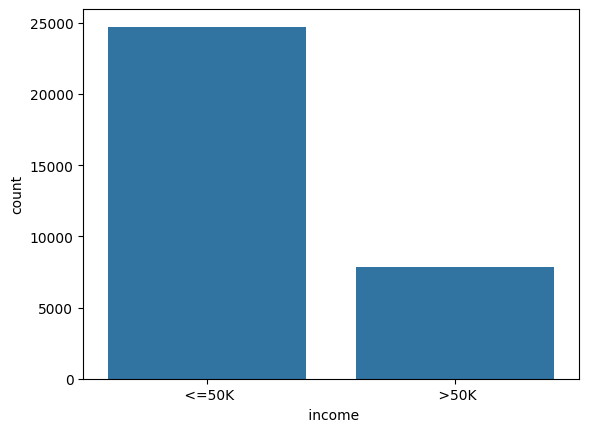

In [ ]:
sns.countplot(data=df, x=' income')

The data is clearly imbalanced with a bias towards <=50K. We will need to use resampling techniques to offset this imbalance.

We will use the SMOTE library from sklearn to oversample the dataset to take care of the imbalance we observed.

In [ ]:
# Initialize SMOTE oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

<ipython-input-299-4b7a5b816da6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Set1')


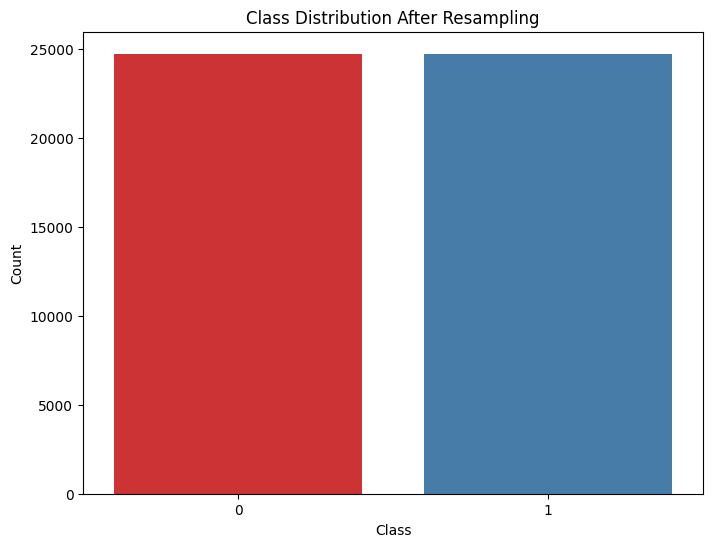

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette='Set1')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After Resampling')
plt.show()

Split the dataset for training and testing. 80% of the values will be used for training while 20% will be used for testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(39552, 13)
(9888, 13)


In [ ]:
# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Decision Tree Classifier

In [ ]:
dt_classifier = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a pipeline with GridSearchCV
pipeline = Pipeline([
    ('clf', GridSearchCV(dt_classifier, param_grid, cv=5, scoring='f1'))
])

pipeline.fit(X_train, y_train)

best_params = pipeline.named_steps['clf'].best_params_
print("Best parameters:", best_params)

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print("\nCross-validation scores:", cv_scores)
print("Mean F1 cross-validation score:", cv_scores.mean())


# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n****TEST PERFROMANCE****")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}\n\n")
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}

Cross-validation scores: [0.83905078 0.84532508 0.8362739  0.83210784 0.84102564]
Mean F1 cross-validation score: 0.8387566494657792

****TEST PERFROMANCE****
Accuracy: 0.8352
Precision: 0.8148
Recall: 0.8681
F1 Score: 0.8406


              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4938
           1       0.81      0.87      0.84      4950

    accuracy                           0.84      9888
   macro avg       0.84      0.84      0.83      9888
weighted avg       0.84      0.84      0.83      9888

